In [7]:
import seaborn as sn
from scipy.stats import norm
import scipy.signal as sig
import copy

In [50]:
def bandpower(ps, mode='psd'):
    """
    estimate bandpower, see https://de.mathworks.com/help/signal/ref/bandpower.html
    """
    if mode=='time':
        x = ps
        l2norm = linalg.norm(x)**2./len(x)
        return l2norm
    elif mode == 'psd':
        return sum(ps) 

def getIndizesAroundPeak(arr, peakIndex,searchWidth=1000):
    peakBins = []
    magMax = arr[peakIndex]
    curVal = magMax
    for i in range(searchWidth):
        newBin = peakIndex+i
        newVal = arr[newBin]
        if newVal>curVal:
            break
        else:
            peakBins.append(int(newBin))
            curVal=newVal
    curVal = magMax
    for i in range(searchWidth):
        newBin = peakIndex-i
        newVal = arr[newBin]
        if newVal>curVal:
            break
        else:
            peakBins.append(int(newBin))
            curVal=newVal
    return np.array(list(set(peakBins)))

def freqToBin(fAxis, Freq):
    return argmin(abs(fAxis-Freq))

def getPeakInArea(psd, faxis, estimation, searchWidthHz = 10):
    """
    returns bin and frequency of the maximum in an area
    """
    binLow = freqToBin(faxis, estimation-searchWidthHz)
    binHi = freqToBin(faxis, estimation+searchWidthHz)
    peakbin = binLow+argmax(psd[binLow:binHi])
    return peakbin, faxis[peakbin]

def getHarmonics(fund,sr,nHarmonics=6,aliased=False):
    harmonicMultipliers = np.arange(2,nHarmonics+2)
    harmonicFs = fund*harmonicMultipliers
    if not aliased:
        harmonicFs[harmonicFs>sr/2] = -1
        harmonicFs = np.delete(harmonicFs,harmonicFs==-1)
    else:
        nyqZone = np.floor(harmonicFs/(sr/2))
        oddEvenNyq = nyqZone%2  
        harmonicFs = np.mod(harmonicFs,sr/2)
        harmonicFs[oddEvenNyq==1] = (sr/2)-harmonicFs[oddEvenNyq==1]
    return harmonicFs 

In [46]:
sr = 48000
T = 0.1 #seconds
N = int(T*sr)
n = np.arange(N)
t = n/sr

silence = np.zeros(N)

SNR by definition, not computation: 16.989700043360187 dB


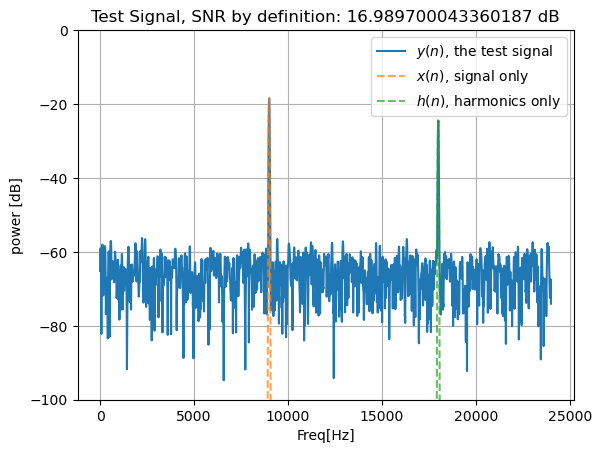

In [47]:
np.random.seed(1) #reproducability

# matlab like randn function, for comparison reasons with matlab code. Only needed to create test signal.
matlabRandn = lambda n:norm.ppf(np.random.rand(1,n)).flatten()

A = 1.0
a = 0.5
s = 0.1
powFund = A**2/2
powHarm = a**2/2
varnoise = s**2
f0 = 9000#*(sr/2)
h1 = f0*2.
noiseOnly = s*matlabRandn(len(t))
signalOnly = A * np.cos(np.pi*2*f0*t)
harmonicsOnly = a*np.sin(np.pi*2*t*h1)
y = signalOnly + harmonicsOnly + noiseOnly

faxis,psX = sig.periodogram(signalOnly,fs=sr, window=('kaiser',38))
faxis,psH = sig.periodogram(harmonicsOnly,fs=sr, window=('kaiser',38))

defSNR = 10*np.log10(powFund/varnoise)
print('SNR by definition, not computation: {} dB'.format(defSNR))

faxis,ps = sig.periodogram(y,fs=sr, window=('kaiser',38))
fundBin = np.argmax(ps) 

_=plt.plot(faxis,10*np.log10(ps), label='$y(n)$, the test signal')
_=plt.plot(faxis,10*np.log10(psX),'--', label='$x(n)$, signal only', alpha=0.7)
_=plt.plot(faxis,10*np.log10(psH),'--', label='$h(n)$, harmonics only', alpha=0.7)
plt.title('Test Signal, SNR by definition: {} dB'.format(defSNR))
plt.ylim([-100,0])
plt.xlabel('Freq[Hz]')
plt.ylabel('power [dB]')
plt.legend()
plt.grid(True)

In [48]:
faxis,ps = sig.periodogram(y,fs=sr, window=('kaiser',38)) #get periodogram, parametrized like in matlab
fundBin = np.argmax(ps) #estimate fundamental at maximum amplitude, get the bin number
fundIndizes = getIndizesAroundPeak(ps,fundBin) #get bin numbers around fundamental peak
fundFrequency = faxis[fundBin] #frequency of fundamental

In [49]:
nHarmonics = 6
harmonicFs = getHarmonics(fundFrequency,sr,nHarmonics=nHarmonics,aliased=True) #get harmonic frequencies
print('harmonic frequencies estimated: {}'.format(harmonicFs))

harmonic frequencies estimated: [18000. 21000. 12000.  3000.  6000. 15000.]


In [61]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from signal_utils import *

In [111]:
import numpy as np
import matplotlib.pyplot as plt

def find_SNR(spectrum_dB, freqs, f_range, bandwidth_bins=5):
    """
    Računanje SNR-a iz spektra i crtanje granica opsega signala.
    """
    f_low, f_high = f_range

    # 1. Opseg interesa
    idx_band = np.where((freqs >= f_low) & (freqs <= f_high))[0]
    freqs_band = freqs[idx_band]
    spectrum_band = spectrum_dB[idx_band]

    # 2. Pik
    idx_peak_local = np.argmax(spectrum_band)
    peak_freq = freqs_band[idx_peak_local]
    signal_level = spectrum_band[idx_peak_local]

    # 3. Indeksi ± bandwidth_bins
    start = max(0, idx_peak_local - bandwidth_bins)
    stop = min(len(spectrum_band), idx_peak_local + bandwidth_bins + 1)

    f_left = freqs_band[start]
    f_right = freqs_band[stop-1]

    # Plot spektra i granica
    plt.figure()
    plt.plot(freqs_band, spectrum_band, 'k-')
    plt.axvline(f_left, color='r', linestyle='--')
    plt.axvline(f_right, color='r', linestyle='--')
    plt.title("Spektar sa označenim signalnim opsegom")
    plt.xlabel("Frekvencija [Hz]")
    plt.ylabel("Amplituda [dB]")
    plt.grid(True)

    # 4. Preostali noise binovi
    idx_exclude_local = np.arange(start, stop)
    idx_noise_local = np.setdiff1d(np.arange(len(spectrum_band)), idx_exclude_local)

    if len(idx_noise_local) == 0:
        raise ValueError("No noise bins left after excluding signal.")

    noise_floor = np.max(spectrum_band[idx_noise_local])

    return signal_level - noise_floor


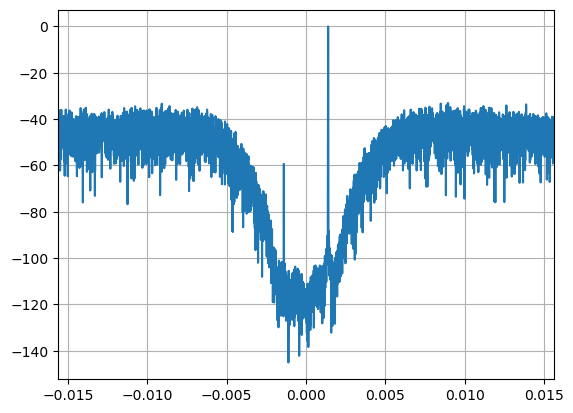

In [114]:
xout_i_stage2 = np.loadtxt("../data/output/16bit/LUT3/kernel3/stage2/xout_i_stage2_054_f0p357.txt", dtype=np.int32)
xout_q_stage2 = np.loadtxt("../data/output/16bit/LUT3/kernel3/stage2/xout_q_stage2_054_f0p357.txt", dtype=np.int32)
xout_i_stage2 = np.where(xout_i_stage2 == 0, -1, 1)
xout_q_stage2 = np.where(xout_q_stage2 == 0, -1, 1)
xout_iq_stage2 = xout_i_stage2 + 1j*xout_q_stage2

freq_out_stage2, xfftdB_out_stage2, an = fftdB(xout_iq_stage2, True)
plt.figure()
plt.plot(freq_out_stage2, xfftdB_out_stage2)
plt.xlim([-0.5/32, 0.5/32])
plt.grid()

90.97849648096727


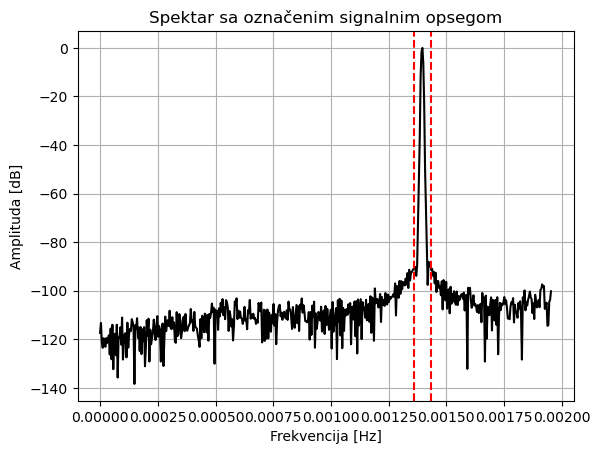

In [119]:
fmin = -0.5/32/8
fmin=0
fmax = 0.5/32/8
bandwidth = 10

SNR = find_SNR(xfftdB_out_stage2, freq_out_stage2, [fmin, fmax], bandwidth)
plt.plot([])
print(SNR)

In [89]:
f_est = 0.357/32/8
fmin = -0.5/32/8
fmin = 0
fmax = 0.5/32/9
psd = xfftdB_out_stage2
faxis = np.linspace(-0.5, 0.5, len(psd))

# recimo da već imaš psd i faxis iz FFT ili Welch analize
snr_db, info = snr_from_psd_roi(psd, faxis, f_est=f_est, fmin=fmin, fmax=fmax,
                                searchWidthHz=20, peak_halfwidth_bins=2,
                                include_harmonics=False)  # True za SINAD
print("SNR =", snr_db, "dB (f0≈", info["f0"], "Hz)")

SNR = nan dB (f0≈ 0.0013980918811488108 Hz)


/tmp/ipykernel_14942/2149404807.py:103: RuntimeWarning: invalid value encountered in log10
  snr_db = 10.0 * np.log10(P_sig / P_noise + 1e-20)
